In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

## Neural networks

---
In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network.

Load the data and view some samples in the same way as [ex3](https://github.com/rickwierenga/CS229-Python/tree/master/ex3).

Remember the output of a neural network: $h_\Theta(x) \in \mathbb{R}^K$. We want y to be a 2 dimensional vector in the form that are network should output. For example, we would represent the output 1 as:

$\begin{bmatrix}0\\1\\0\\0\\0\\0\\0\\0\\0\\0\end{bmatrix}$

In [25]:
def remap(y, K):
    m = len(y)
    out = np.zeros((m, K))
    for index in range(m):
        out[index][y[index] - 1] = 1
    return out

In [26]:
import scipy.io as sio

# Load data
data = sio.loadmat("ex4data1.mat")
X = data["X"]
y = data["y"]
y = y.reshape(len(y))

# Initialize some useful variables
m, n = X.shape
input_layer_size = 400
hidden_layer_size = 25
K = 10 # number of classes / output_layer_size

# remap y
mapped_y = remap(y, K)

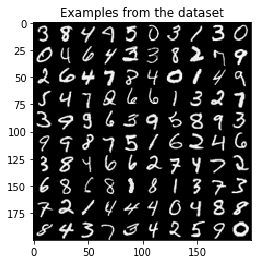

In [27]:
import random
from PIL import Image

# get 100 random images from the dataset
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# loop over the images, turn them into a PIL image
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose() # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

Load the provided weights.

In [28]:
# load the pretrained weights
theta = sio.loadmat("ex4weights.mat")
theta_1 = theta['Theta1']
theta_2 = theta['Theta2']
nn_params = np.concatenate([theta_1.flatten(), theta_2.flatten()])

### Feedforward
These are the functions for doing feedforward as written [ex3](https://github.com/rickwierenga/CS229-Python/tree/master/ex3).

In [29]:
def sigmoid(z):
    """implementation of sigmoid function"""
    return 1 / (1 + np.exp(-z))

def add_bias(X):
    """add bias node to X"""
    m = len(X)
    bias = np.ones((m, 1))
    X = np.hstack((bias, X))
    return X

def forward(theta, X):
    """implementation of forward propagation that compute ℎ𝜃(𝑥(𝑖)) """
    return sigmoid(X@theta.T)

### Cost Function

Remember the following variables from the lectures: 

* $L$: Total number of layers in the network
* $s_l$: number of units (not counting bias unit) in layer $l$.
* $K$: number of output classes

The cost function for neural networks without regularization:

$$J(\theta) = \frac{1}{m}\displaystyle\sum_{i=1}^{m}\displaystyle\sum_{k=1}^{K}\begin{bmatrix} -y^{(i)}_k \log (h_\theta(x^{(i)}) - (1 - y^{(i)})_k \log(1-(h_\theta(x^{(i)}))_k)\end{bmatrix}$$

And with regularization:

$$J(\theta) = -\frac{1}{m}\displaystyle\sum_{i=1}^{m}\displaystyle\sum_{k=1}^{K}\begin{bmatrix} -y^{(i)}_k \log ((h_\theta(x^{(i)}-(1-y^{(i)})_k) \log(1-(h_\theta(x^{(i)}))_k)\end{bmatrix} + \frac{\lambda}{2m} \displaystyle\sum_{l=1}^{L-1}\displaystyle\sum_{i=1}^{s_l}\displaystyle\sum_{j=1}^{s_l+1}(\Theta^{(l)}_{ji})^2$$

The double sum adds up the costs for each cell in the output layer. The triple sum adds up the squares of all $\Theta$s in the network.

**Exercise**: Implement the cost function for neural networks, `compute_nn_cost`, in Python. There are some structural comments to help you.

In [30]:
def compute_nn_cost(nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda=0):
    """compute the cost function for neural network, 
    using the parameters nn_params, input_layer_size, hidden_layer_size, K, _lambda"""
    m = len(y)
    # Extract theta_1 and theta_2 from nn_params
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1))
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (K, hidden_layer_size + 1))
    # Feed forward the network to get the predictions
    prediction = forward(theta2, add_bias(forward(theta1, add_bias(X))))
    # Compute the cost of the current prediction
    network_cost = (1/m) * np.sum(-(y*np.log(prediction) + (1-y)*np.log(1 - prediction)))
    regularization = (_lambda/(2*m)) * (np.sum(np.square(theta1)) + np.sum(np.square(theta2)))
    return network_cost + regularization

In [31]:
J = compute_nn_cost(nn_params, X, mapped_y,
                    input_layer_size=input_layer_size,
                    hidden_layer_size=hidden_layer_size,
                    K=10)
_lambda = 1
J_reg = compute_nn_cost(nn_params, X, mapped_y,
                        input_layer_size=input_layer_size,
                        hidden_layer_size=hidden_layer_size,
                        K=10,
                        _lambda=_lambda)

print('Cost without regularization: {:2}% (0.29 approx)'.format(J))
print('Cost with regularization: {:2}% (0.38 approx)'.format(J_reg))

Cost without regularization: 0.2876291651613189% (0.29 approx)
Cost with regularization: 0.384487796242894% (0.38 approx)


## Backpropogation

---

### The Algorithm
As the name suggests, backpropogation is roughly the opposite of feedforward propogation. Backpropogation is an algorithm that trains neural networks by computing the gradient and thereupon applying it to the neural network.

Backpropogation (Backprop) starts at the end of the network. It finds the difference between the output of the neural network and the desired output. This value gets stored in $\delta_j^{(l)}$, the error/cost for $a_j^{(l)}$. Also, $\frac{\delta}{\delta z_j^{(l)}} = \delta_j^{(l)}$. The process formaly:

$$\delta_j^{(l)} = a_j^{(l)} - y_j$$ for $l = L$

$$\delta_j^{(l)} = (\Theta^{(l)})^T\delta^{(l+1)} .* g'(z^{(l)}) = (\Theta^{(l)})^T\delta^{(l+1)} .* \delta^{(l)}$$ for $L > l > 1$

Also: 

$$D^{(l)}_{ij} = \frac{\delta}{\delta \Theta_j^{(l)}}J(\Theta)$$

As you would probably have expected, we don't apply the gradient to the input layer, layer 1, because we don't want to change our input in order to get a better output.

The complete algorithm:

Set $\Delta^{(l)}_{ij} = 0$ for all ($l$, $i$, $j$)

for $i = $ to $m$
1. Perform forward propogation to compute $a^{(l)}$ for $l = 2, 3, ..., L$
2. Using $y^{(l)}$, compute $\delta^{(L)} = a^{(L)} - y^{(i)}$
3. Compute $\delta^{(L-2)}$, ..., $\delta^{(2)}$
4. $\Delta^{(l)}_{ij} := \Delta^{(l)}_{ij} + a^{(l)}_j\delta^{(l+1)}_i$

$D^{(l)}_{i0} = \frac{1}{m}\Delta^{(l)}_{i0}$

$D^{(l)}_{ij} = \frac{1}{m}\Delta^{(l)}_{ij} + \lambda\Theta^{(l)}_{ij}$ if y $\neq 0$

### Gradient Checking
After you've implemented code to compute the gradient, it's often a good idea to validate your code by comparing the gradient to an approximation of it. The approximiation is defined as: 

$$\frac{J(\theta+\epsilon) - J(\theta-\epsilon)}{2\epsilon} \approx D$$

### Random Initialization

If all values in the neural networks are the same, the neural network will fail to develop advanced patterns and it will not function. This is the reason we use a random value for theta as the initial input (break the symmetry).

### Neural Network Traning
Follow these steps when training a neural network:
1. Randomly initialize weights (avoid **symmetric ... **)
2. Implement forward propogation to get $h_\Theta(x^{(i)})$ from any $x^{(i)}$.
3. Implement code to compute cost function $J(\Theta)$.
4. Implement backprop to compute partial derrivatives $\frac{\delta}{\delta \Theta^{(l)}_{jk}}J(\Theta)$. 
    * Usually with a for loop over the training examples:
        * Perform forward and backward propogation using one example
        * Get activations $a^{(l)}$ and delta terms $d^{(l)}$ for $l = 2, ..., L$
5. Use gradient checking to compare $\frac{\delta}{\delta \Theta^{(l)}_{jk}}J(\Theta)$ computed using back propogation vs. using numerical estate of gradient of $J(\Theta)$. Then disable gradient checking code.
6. Use gradient descent or advanced optimization method with backpropogation to try to minimize $J(\Theta)$ as a function of parameters $\Theta$.

---

In this part of the exercise, you will implement the backpropagation algorithm to compute the gradient for the neural network cost function. Once you have computed the gradient, you will be able to train the neural network by minimizing the cost function $J(\theta)$ using an advanced optimization algorithm such as cg.

### Sigmoid Gradient
**Exercise**: Implement the gradient for the sigmoid function.

In [32]:
def sigmoid_gradient(z):
    """implementation of the gradient computing for sigmoid function"""
    result = np.multiply(sigmoid(z), (1-sigmoid(z)))
    return result

### Initializing Parameters
**Exercise**: Initialize random weights.

In [33]:
def initialize_random_weights(L_in, L_out):
    """initializing random weight"""
    epsilon = 0.12
    W = np.random.rand(L_out, L_in + 1) * (2 * epsilon) - epsilon
    return W

In [34]:
initial_theta_1 = initialize_random_weights(input_layer_size, hidden_layer_size)
initial_theta_2 = initialize_random_weights(hidden_layer_size, K)
initial_nn_parameters = np.concatenate([initial_theta_1.flatten(), initial_theta_2.flatten()])

### Implement backpropogation
**Exercise**: Implement back propogation in Python

In [41]:
def backprop_gradient(nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda=None):
    """the implementation of back propogation algo,
    using the parameters nn_params, input_layer_size, hidden_layer_size, K, _lambda """
    m = X.shape[0]
    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, input_layer_size + 1))
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], (K, hidden_layer_size + 1))
    
    prediction = forward(theta2, add_bias(forward(theta1, add_bias(X))))
    
    delta3 = np.subtract(prediction, y);
    delta2 = (delta3@theta2[:,1:]) * sigmoid_gradient(add_bias(X) @ theta1.T)
    bigDelta1 = add_bias(X).T @ delta2
    bigDelta2 = add_bias(forward(theta1, add_bias(X))).T @ delta3
    Theta1_grad = (1/m) * bigDelta1.T
    Theta2_grad = (1/m) * bigDelta2.T
    Theta1_grad[:, 1:] += (_lambda/m) * theta1[:, 1:]
    Theta2_grad[:, 1:] += (_lambda/m) * theta2[:, 1:]
    nn_params = np.concatenate([Theta1_grad.flatten(), Theta2_grad.flatten()])
    return nn_params

In [42]:
# This cell contains functions for testing the gradient. You do not have to understand them.
def debug_initialize_weights(fan_out, fan_in):
    W = np.sin(np.arange(1, (fan_in + 1) * fan_out + 1)) / 10
    return W.reshape(fan_out, fan_in + 1)

def compute_numerical_gradient(cost_function, nn_params, X, y, input_layer_size, hidden_layer_size, K, _lambda):
    numgrad = np.zeros(nn_params.shape)
    perturb = np.zeros(nn_params.shape)
    e = 1e-4
    for p in range(len(nn_params)):
        # Set pertubation vector
        perturb[p] = e
        loss_1 = cost_function(nn_params-perturb, X, y, 
                               input_layer_size=input_layer_size, 
                               hidden_layer_size=hidden_layer_size, 
                               K=K, 
                               _lambda=_lambda)
        loss_2 = cost_function(nn_params+perturb, X, y, 
                               input_layer_size=input_layer_size, 
                               hidden_layer_size=hidden_layer_size, 
                               K=K, 
                               _lambda=_lambda)
        
        # Compute numerical gradient
        numgrad[p] = (loss_2 - loss_1) / (2*e)
        perturb[p] = 0
    return numgrad

def check_gradient(cost_function, gradient_function, _lambda=0):
    """ Check the gradient function """

    # Initialize test values
    input_layer_size = 3
    hidden_layer_size = 5
    K = 3
    m = 5
    
    theta_1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    theta_2 = debug_initialize_weights(K, hidden_layer_size)
    X = debug_initialize_weights(m, input_layer_size - 1)
    y = 1 + np.mod(np.arange(1, m+1), K)
    out = np.zeros((m, K))
    for index in range(m):
        out[index][y[index] - 1] = 1
    y = out
    
    # Unroll parameters
    nn_params = np.concatenate([theta_1.flatten(), theta_2.flatten()])
    
    # Compute gradient via backprop
    backprop_gradient = gradient_function(nn_params, X, y,
                                          input_layer_size=input_layer_size,
                                          hidden_layer_size=hidden_layer_size,
                                          K=K,
                                          _lambda=_lambda)
    
    # Compute numerical gradient
    numerical_gradient = compute_numerical_gradient(cost_function, nn_params, X, y,
                                                    input_layer_size=input_layer_size,
                                                    hidden_layer_size=hidden_layer_size,
                                                    K=K,
                                                    _lambda=_lambda)
    
    # Compare the backprop and numerical gradient
    gradients = pd.DataFrame({'Backprop': backprop_gradient, 
                              'Numerical': numerical_gradient, 
                              'Difference':np.abs(backprop_gradient - numerical_gradient)})
    pd.options.display.max_rows = 5
    print(gradients)
    
    # Compute the difference
    diff = np.linalg.norm(numerical_gradient - backprop_gradient) / np.linalg.norm(backprop_gradient + numerical_gradient)
    print('If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: {}'.format(diff))

Test the backpropogation algorithm (with and without regularization)

In [43]:
print('The gradients without regularization: ')
check_gradient(compute_nn_cost, backprop_gradient)

print('\n-------------\n')

print('The gradients with regularization (lambda=3): ')
check_gradient(compute_nn_cost, backprop_gradient, _lambda=3)

The gradients without regularization: 
    Backprop  Numerical    Difference
0   0.012316   0.012316  9.615204e-12
1   0.000174   0.000174  9.094188e-13
..       ...        ...           ...
36  0.054741   0.054741  8.854098e-13
37  0.050293   0.050293  1.425832e-12

[38 rows x 3 columns]
If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: 1.9062170136081537e-11

-------------

The gradients with regularization (lambda=3): 
    Backprop  Numerical    Difference
0   0.012316   0.062804  5.048826e-02
1   0.054732   0.054732  3.022305e-13
..       ...        ...           ...
36 -0.002943  -0.002943  1.112353e-12
37  0.005234   0.005234  7.030904e-13

[38 rows x 3 columns]
If the backprop gradient is computed well, the relative diffrence will be no more than 1e-9: 0.10794204496458813


### Training the neural network

The neural network will now be trained using your functions.

In [44]:
# Get random initial values for theta
initial_theta_1 = initialize_random_weights(input_layer_size, hidden_layer_size)
initial_theta_2 = initialize_random_weights(hidden_layer_size, K)
initial_nn_parameters = np.concatenate([initial_theta_1.flatten(), initial_theta_2.flatten()])

# Set config
_lambda = 1
args = (X, mapped_y, input_layer_size, hidden_layer_size, K, _lambda)

# Train NN
result = minimize(compute_nn_cost, initial_nn_parameters, args=args,
                            method='CG', jac=backprop_gradient, 
                            options={"maxiter": 50, "disp" : 1})
nn_params = result.x
theta_1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, (input_layer_size + 1)))
theta_2 = nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((K, (hidden_layer_size + 1)))

         Current function value: 0.469930
         Iterations: 50
         Function evaluations: 105
         Gradient evaluations: 105


### Visualising the hidden layer

You can now "visualize" what the neural network is learning by displaying the hidden units to see what features they are capturing in the data.

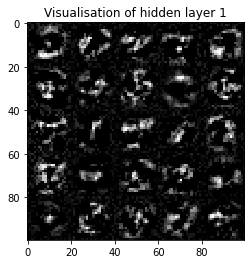

In [45]:
# get 100 random images from the dataset
num_samples = 100
hidden_unit_visual = theta_1[:, 1:]
display_img = Image.new('RGB', (100, 100))

# loop over the images, turn them into a PIL image
i = 0
for col in range(5):
    for row in range(5):
        array = hidden_unit_visual[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose() # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Visualisation of hidden layer 1')
plt.imshow(display_img, interpolation='nearest')

### Evaluating the model

Get the accuracy on the training set for the trained values of theta. According to the exercise, you should have an accuracy of about 95%. However, this may vary due to the random initalization.

In [46]:
# Make sure to add 1 to the result as `y` is one indexed while the prediction is 0 indexed.
predictions = forward(theta_2, add_bias(forward(theta_1, add_bias(X))))
accuracy = np.mean(np.argmax(predictions, axis = 1) + 1 == y) * 100
'Training set accuracy using the a neural network with the trained values for theta: {:2}%'.format(accuracy)

'Training set accuracy using the a neural network with the trained values for theta: 95.64%'